In [3]:
import tensorflow as tf 
from tensorflow.keras import models,layers 
import matplotlib.pyplot as plt 

In [4]:
ImageSize =256 
BatchSize =32 

In [5]:
dataset = tf.keras.preprocessing .image_dataset_from_directory(
    "PlantVillage" ,
    shuffle=True,
    image_size=(ImageSize,ImageSize) ,
    batch_size = BatchSize
)
    


Found 2152 files belonging to 3 classes.


In [6]:
class_names =dataset.class_names
class_names 

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
68*32

2176

In [9]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [107]:
for img_batch , label_batch in dataset.take(1):
    print (label_batch)
    print (label_batch.shape)
    print (img_batch[0])
    

tf.Tensor([1 1 0 1 0 0 0 0 1 1 1 1 1 1 2 1 0 0 1 1 0 0 0 1 1 0 2 0 1 0 0 1], shape=(32,), dtype=int32)
(32,)
tf.Tensor(
[[[166. 162. 176.]
  [172. 168. 182.]
  [177. 173. 187.]
  ...
  [163. 161. 175.]
  [164. 162. 176.]
  [164. 162. 176.]]

 [[167. 163. 177.]
  [171. 167. 181.]
  [175. 171. 185.]
  ...
  [163. 161. 175.]
  [164. 162. 176.]
  [164. 162. 176.]]

 [[168. 164. 178.]
  [171. 167. 181.]
  [172. 168. 182.]
  ...
  [163. 161. 175.]
  [164. 162. 176.]
  [164. 162. 176.]]

 ...

 [[104.  96. 109.]
  [115. 107. 120.]
  [118. 110. 123.]
  ...
  [112. 106. 120.]
  [129. 123. 137.]
  [119. 113. 127.]]

 [[100.  92. 105.]
  [111. 103. 116.]
  [102.  94. 107.]
  ...
  [ 75.  69.  83.]
  [126. 120. 134.]
  [120. 114. 128.]]

 [[100.  92. 105.]
  [ 85.  77.  90.]
  [107.  99. 112.]
  ...
  [141. 135. 149.]
  [ 93.  87. 101.]
  [110. 104. 118.]]], shape=(256, 256, 3), dtype=float32)


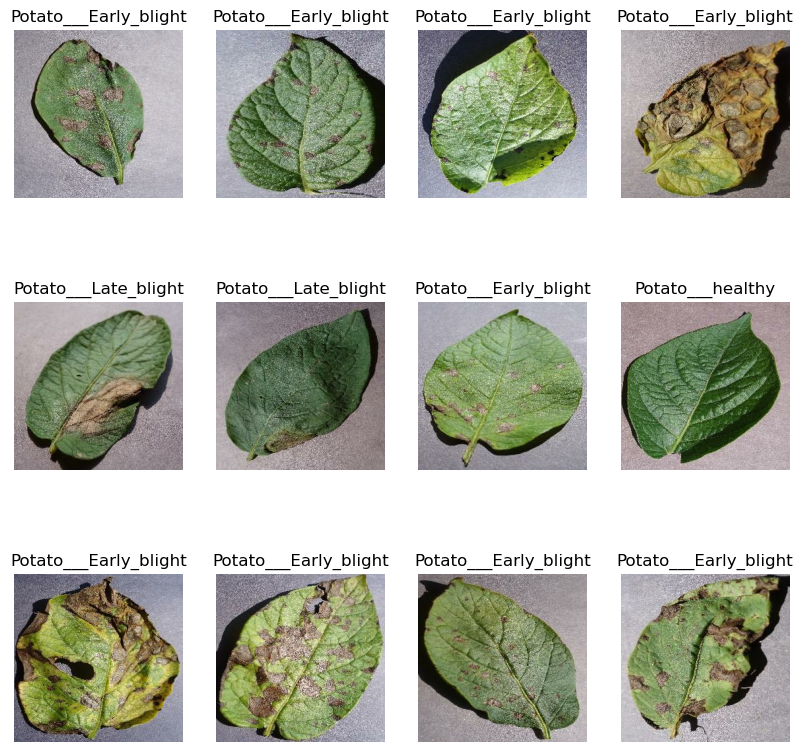

In [54]:
plt.figure(figsize=(10,10))
for img_batch , label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.axis('off')
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
    


### 80% ==> training 
### 20% ==> 10% validation , 10% test

In [61]:
train_size = 0.8
len(dataset)*train_size 

54.400000000000006

In [65]:
train_Ds = dataset.take(54)
len(train_Ds)

54

In [67]:
test = dataset.skip(54)
len(test)

14

In [71]:
val_Ds = test.take(7)
test_Ds = test.skip(7)

In [81]:
def get_dataset_partitions_tf(ds , train_split= 0.8 , val_split = 0.1 , test_split= 0.1 , shuffle=True , shuffle_size = 1000 ):
    ds_size=len(ds)
    if shuffle :
        ds=ds.shuffle(shuffle_size, seed =12)
        # what does seed do???????
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_Ds = ds.take(train_size)
    
    val_Ds = ds.skip(train_size).take(val_size) 
    test_Ds = ds.skip(train_size).skip(val_size)

    return train_Ds , val_Ds , test_Ds 



In [83]:
train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [85]:
len(train_ds)

54

In [138]:
len(test_ds)

8

In [140]:
len(val_ds)

6

In [89]:
#cache stores the data in cache for the next epoch 
# prefetch--> CPU fetches the next batch while GPU is trining the current batch (but you dont have a GPU :)  )
# buffer_size lets it decide how many batch to load while GPU is training

In [91]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [99]:
# train_ds = train_ds.map(lambda x: x/255)
resize_and_rescale= tf.keras.Sequential([
    layers.Resizing(ImageSize, ImageSize),
    layers.Rescaling(1.0/255)
])

In [103]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical") , 
    layers.RandomRotation(0.2) 
])

# model

In [124]:
input_shape = (BatchSize , ImageSize , ImageSize , 3)
model = models.Sequential([
    resize_and_rescale , 
    data_augmentation ,
    layers.Conv2D(32 , (3,3) ,activation='relu' , input_shape = input_shape),
    layers.MaxPooling2D((2,2)),              
    layers.Conv2D(64 , (3,3) ,activation='relu' ),
    layers.MaxPooling2D((2,2)),              
    layers.Conv2D(64 , (3,3) ,activation='relu' ),
    layers.MaxPooling2D((2,2)),              
    layers.Conv2D(64 , (3,3) ,activation='relu' ),
    layers.MaxPooling2D((2,2)),              
    layers.Conv2D(64 , (3,3) ,activation='relu'),
    layers.MaxPooling2D((2,2)),              
    layers.Conv2D(64 , (3,3) ,activation='relu'),
    layers.MaxPooling2D((2,2)),  
    layers.Flatten() ,
    layers.Dense(64 , activation= 'relu'),
    layers.Dense(3 , activation= 'softmax'),
                 
                  
])
model.build(input_shape=input_shape)

In [126]:
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [144]:
model.compile(
    optimizer = 'adam' ,
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics= ['accuracy']
    
)

In [146]:
history = model.fit(
    train_ds , 
    epochs=50 ,
    batch_size = BatchSize ,
    verbose =1 , 
    validation_data = val_ds ,
    
    
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4688 - loss: 0.9386 - val_accuracy: 0.6979 - val_loss: 0.7961
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 947ms/step - accuracy: 0.6870 - loss: 0.7369 - val_accuracy: 0.6510 - val_loss: 0.8030
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 937ms/step - accuracy: 0.7730 - loss: 0.5476 - val_accuracy: 0.8750 - val_loss: 0.3453
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 78s 854ms/step - accuracy: 0.8401 - loss: 0.3908 - val_accuracy: 0.9219 - val_loss: 0.2483
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 943ms/step - accuracy: 0.9041 - loss: 0.2663 - val_accuracy: 0.9219 - val_loss: 0.2176
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 855ms/step - accuracy: 0.9095 - loss: 0.2240 - val_accuracy: 0.9323 - val_loss: 0.1663
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 926ms/step - accuracy: 0.9235 - loss: 0.1965 - val_accuracy: 0.9375 - val_loss: 0.1873
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 934ms/step - accuracy: 0.9398 - loss: 0.1539 - val_accurac

In [150]:
score  = model.evaluate(test_ds )

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.8971 - loss: 0.3039


In [152]:
score

[0.30923137068748474, 0.90625]

In [158]:
history

In [160]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [162]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [166]:
history.history['accuracy']

[0.4895833432674408,
 0.7106481194496155,
 0.8032407164573669,
 0.8466435074806213,
 0.8998842835426331,
 0.9178240895271301,
 0.9276620149612427,
 0.9403935074806213,
 0.9346064925193787,
 0.9461805820465088,
 0.9554398059844971,
 0.9560185074806213,
 0.953125,
 0.9398148059844971,
 0.9623842835426331,
 0.9618055820465088,
 0.96875,
 0.9571759104728699,
 0.9681712985038757,
 0.9809027910232544,
 0.9450231194496155,
 0.9675925970077515,
 0.9745370149612427,
 0.9722222089767456,
 0.9826388955116272,
 0.9728009104728699,
 0.9756944179534912,
 0.9722222089767456,
 0.9791666865348816,
 0.9780092835426331,
 0.9826388955116272,
 0.9924768805503845,
 0.9855324029922485,
 0.9733796119689941,
 0.9872685074806213,
 0.9866898059844971,
 0.9855324029922485,
 0.9733796119689941,
 0.9809027910232544,
 0.9913194179534912,
 0.9664351940155029,
 0.9832175970077515,
 0.9918981194496155,
 0.9826388955116272,
 0.9895833134651184,
 0.9953703880310059,
 0.9739583134651184,
 0.9751157164573669,
 0.9918981194

In [168]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



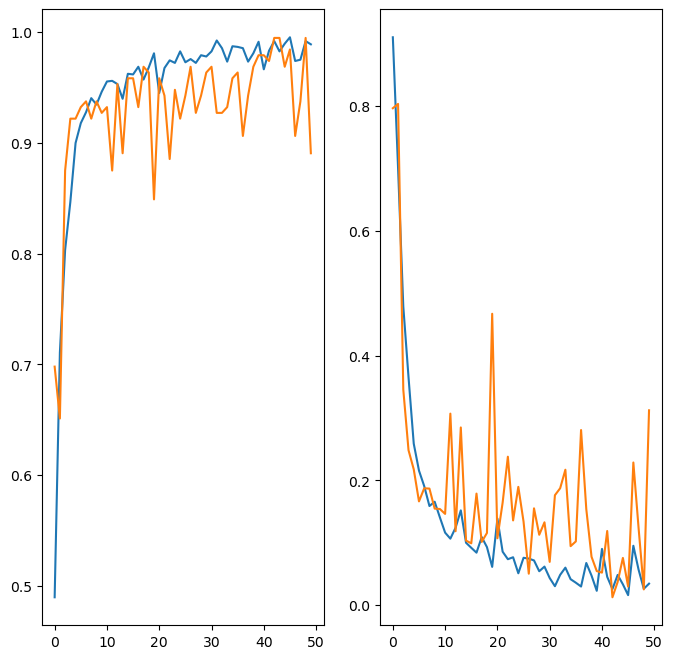

In [184]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50) , acc)

plt.plot(range(50) , val_acc)
plt.subplot(1,2,2)
plt.plot(range(50) , loss)
plt.plot(range(50) , val_loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


NameError: name 'argmax' is not defined

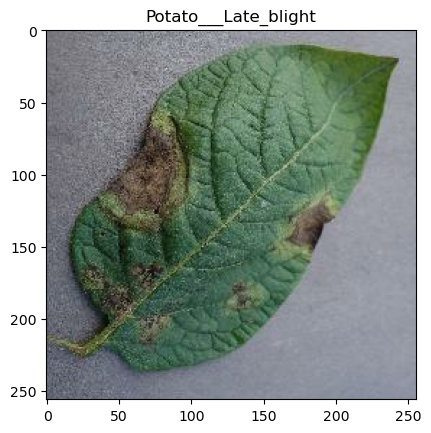

In [204]:
for img , lab in test_ds.take(1):
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.title(class_names[lab[0].numpy()])

    batch_pred = model.predict(img)
    print(argmax(batch_pred[0]))

In [200]:
batch_pred[0]

array([2.9354844e-05, 9.9997067e-01, 3.2562875e-10], dtype=float32)